# Neuron Model Prediction Demo - Computer Vision
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import numpy as np
import cv_helper_class
from cv_helper_class import ImgClassificationNet, Yolov5Net, VisionTransformerNet
import matplotlib.pyplot as plt
from common import preprocess_img
import torch
import torch.neuron
from torchvision import models

<br>

## 1. Image classification (VGG, ResNet, ResNeXT, EfficientNet)

In [3]:
IMGCLS_NETWORK = "RESNET"
assert(IMGCLS_NETWORK in ["VGG", "RESNET", "RESNEXT", "EFFICIENTNET"])

if IMGCLS_NETWORK == "VGG":
    ## Choose the network size
    VGG_SIZE = "11" # can be 11,11_bn,13,13_bn,16,16_bn,19,19_bn
    assert(VGG_SIZE in ['11','11_bn','13','13_bn','16','16_bn','19','19_bn'])
    model_name = f"models.vgg{VGG_SIZE}"
elif IMGCLS_NETWORK == "RESNET":
    RESNET_SIZE = 50 # can be 18,34,50,101,152   
    assert(RESNET_SIZE in [18,34,50,101,152])
    model_name = f"models.resnet{RESNET_SIZE}"
elif IMGCLS_NETWORK == "RESNEXT":
    RESNEXT_SIZE="50_32x4d" # can be 50_32x4d,101_32x8d,101_64x4d
    assert(RESNEXT_SIZE in ['50_32x4d','101_32x8d','101_64x4d'])
    model_name=f"models.resnext{RESNEXT_SIZE}"
elif IMGCLS_NETWORK == "EFFICIENTNET":
    EFFICIENTNET_SIZE = 0 # can be 0,1,2,3,4,5,6,7
    assert(EFFICIENTNET_SIZE in range(8))
    model_name = f"models.efficientnet_b{EFFICIENTNET_SIZE}"
    
model_name_eval = eval(model_name)
model = model_name_eval(pretrained=True) 
imgclass_net = ImgClassificationNet(model=model, model_name=model_name)

/home/ubuntu/pytorch_venv/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/ubuntu/pytorch_venv/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Load Neuron model

In [4]:
imgclass_net.analyze()
imgclass_net.compile()
#imgclass_net.load("neuron_models.resnet50.pt")

load from filepath


/home/ubuntu/pytorch_venv/lib/python3.7/site-packages/torch/serialization.py:709: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


RecursiveScriptModule(
  original_name=AwsNeuronGraphModule
  (_NeuronGraph#0): RecursiveScriptModule(original_name=NeuronModuleV2)
)

In [5]:
img1 = preprocess_img.load_sample_imgA()

### Predict single image

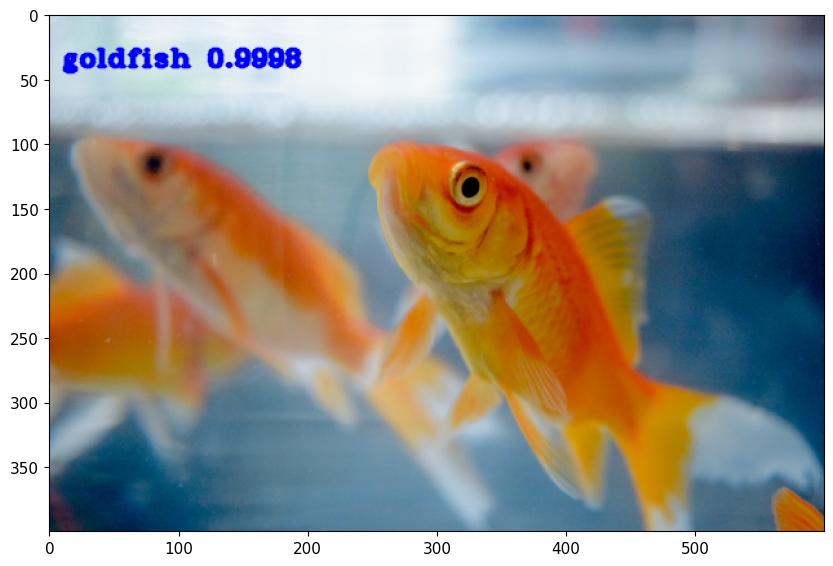

In [6]:
%matplotlib inline
resize_img, y_pred, y_str, y_prob = imgclass_net.get_single_predict_result(img1)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))

### Predict multiple images

In [7]:
img1 = preprocess_img.load_sample_imgA()
img2 = preprocess_img.load_sample_imgE()
img1 = preprocess_img.preprocess_imagenet(img1)
img2 = preprocess_img.preprocess_imagenet(img2)
img_list = [img1, img2]
import numpy as np
x = np.concatenate(img_list, axis=0)
outputs = imgclass_net.predict(x, data_parallel=True)
print(outputs.shape)

torch.Size([2, 1000])


/home/ubuntu/pytorch_venv/lib/python3.7/site-packages/torch_neuron/data_parallel.py:220: UserWarning: The NeuronCores are not being fully utilized because `inputs.shape[dim]` is not divisible by the number of NeuronCores given in `device_ids`. In order to get optimal performance, please try to ensure that the shape your inputs at `dim` is divisible by the number of NeuronCores that DataParallel is using, such that `input.shape[dim] % len(device_ids) == 0).`
  warnings.warn('The NeuronCores are not being fully utilized because '



<br>

## 2. Vision Transformers

In [8]:
import types
from transformers import ViTFeatureExtractor, ViTForImageClassification

model_name = "vit-base-patch16-224"
model_type = "vit"
model = ViTForImageClassification.from_pretrained(f"google/{model_name}")
vit_net = VisionTransformerNet(model=model, model_name=model_name, model_type=model_type)


vit


### Load Neuron model

In [9]:
vit_net.analyze()
vit_net.compile()

In [10]:
#vit_net.load('neuron_vit-base-patch16-224.pt')

load from filepath


RecursiveScriptModule(
  original_name=AwsNeuronGraphModule
  (_NeuronGraph#0): RecursiveScriptModule(original_name=NeuronModuleV2)
)

In [11]:
img1 = preprocess_img.load_sample_imgA()
img2 = preprocess_img.load_sample_imgB()

### Predict single image

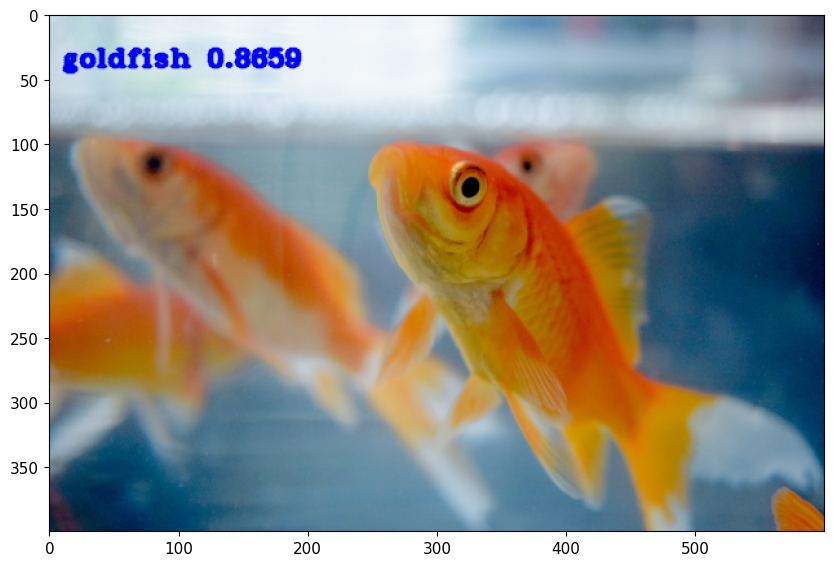

In [12]:
%matplotlib inline
resize_img, y_pred, y_str, y_prob = vit_net.get_single_predict_result(img1)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB))

### Predict multiple images

In [13]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
#x = feature_extractor(img1, return_tensors="pt")['pixel_values']
x = feature_extractor([img1, img2], return_tensors="pt")['pixel_values'] # multiple images
outputs = vit_net.predict(x, data_parallel=True)
outputs.shape

torch.Size([2, 1000])

<br>

## 3. Object Detection (YOLOv5)

In [14]:
model_type = 'l'
assert(model_type in ['n', 's', 'm', 'l', 'x'])
model_name = f'yolov5{model_type}'  
model = torch.hub.load('ultralytics/yolov5', model_name, pretrained=True)

Using cache found in /home/ubuntu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-19 Python-3.7.16 torch-1.12.1+cu102 CPU

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


In [15]:
yolo_net = Yolov5Net(model=model, model_name=model_name, img_size=640)

In [16]:
yolo_net.analyze()
yolo_net.compile()

### Load Neuron model

In [17]:
#yolo_net.load("neuron_yolov5l.pt")

load from filepath


RecursiveScriptModule(
  original_name=AwsNeuronGraphModule
  (_NeuronGraph#0): RecursiveScriptModule(original_name=NeuronModuleV2)
)

In [18]:
img1 = preprocess_img.load_sample_imgA()
img2 = preprocess_img.load_sample_imgB()
x1 = preprocess_img.preprocess_coco(img1)
x2 = preprocess_img.preprocess_coco(img2)
img_list = [x1, x2]
import numpy as np
x = np.concatenate(img_list, axis=0)

### Predict single image

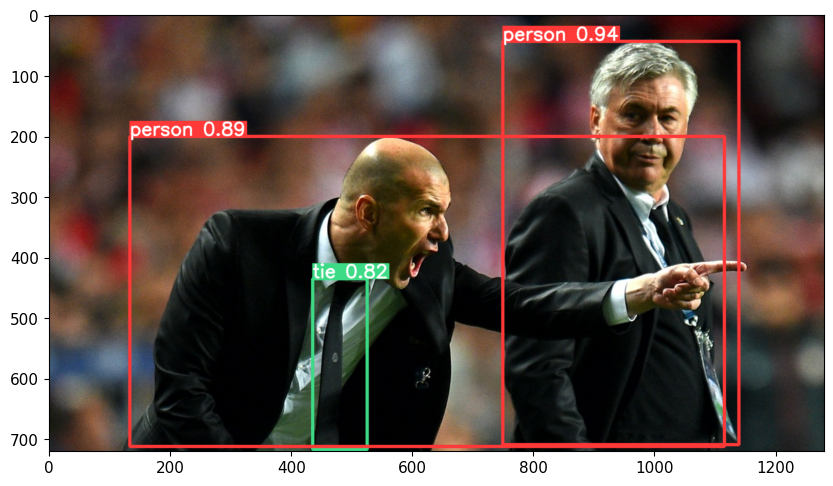

In [19]:
%matplotlib inline
out_img = yolo_net.get_single_predict_result(img2)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

### Predict multiple images

In [20]:
x1 = preprocess_img.preprocess_coco(img1)
x2 = preprocess_img.preprocess_coco(img2)
img_list = [x1, x2]
x = np.concatenate(img_list, axis=0)
outputs = yolo_net.predict(x)
print(outputs.shape)

torch.Size([2, 25200, 85])
